In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy.stats import norm
import scipy.constants as scp
from scipy.integrate import quad
from tabulate import tabulate
from scipy import signal

---

# Abszisseneichung

Steigung: -0.003410929143446487  mm/pixel


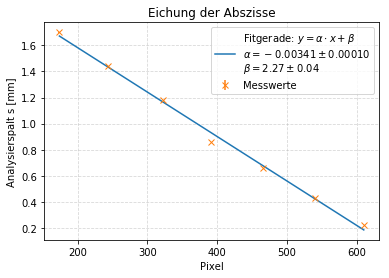

In [2]:
# Messwerte Abszisseneichung:
pixel = np.array([174, 243, 322, 391, 466, 540, 610])
s = np.array([0.850, 0.720, 0.590, 0.430, 0.330, 0.215, 0.110]) * 2
ds = np.full(7, 0.0005) * 2


def linear(x,a,b):
    return a*x+b

popt, pcov = curve_fit(linear, pixel, s, sigma=ds)

plt.grid(alpha=0.5, linestyle='--')
plt.plot(pixel, linear(pixel, *popt), 
        label="\n".join([r"Fitgerade: $y = \alpha \cdot x + \beta$", 
                          r'$\alpha ={:.5f}\pm{:.5f}$'.format(popt[0], np.sqrt(pcov[0][0])), 
                          r'$\beta ={:.3}\pm{:.1}$'.format(popt[1], np.sqrt(pcov[1][1]))]))
plt.errorbar(pixel,s, yerr=ds, linestyle='None', marker='x', label='Messwerte')
plt.xlabel('Pixel')
plt.ylabel('Analysierspalt s [mm]')
plt.title('Eichung der Abszisse')
plt.legend()
plt.savefig('./output/Abszisseneichung.pdf', format='PDF')
print("Steigung:" ,popt[0], " mm/pixel")

#Eichunskoeffizient:
eich = (-popt[0]) #mm/px
deich = np.sqrt(pcov[0][0]) 

# Beugungsbilder Einzelspalt

Benennung der Messwerte: 

Einzelspalt/Doppelspalt (s/d) - positive/negative Ordnung (p/n) - Minimum/Maximum (min/max)

Bsp.: Einzelspalt alle positiven Maxima: 's_p_max'

In [3]:
#Messwerte: 
s_p_min = np.array([706, 778, 850, 921, 993, 1068]) #pixel
s_n_min = np.array([558, 486, 411, 338, 267, 192])
s_p_max = np.array([736, 813, 884, 956, 1028])
s_n_max = np.array([527, 450, 379, 304, 230])

dpixel_min = np.full(6, 5)
dpixel_max = np.full(5, 5)

ordn_s_min = np.arange(1, 7)
ordn_s_max = np.arange(1, 6)

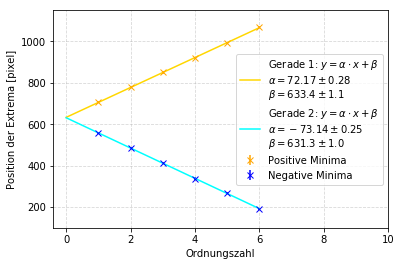

In [4]:
def linear(x, a, b):
    return a*x+b

opt_s_p_min, cov_s_p_min = curve_fit(linear, ordn_s_min, s_p_min, sigma=dpixel_min)
opt_s_n_min, cov_s_n_min = curve_fit(linear, ordn_s_min, s_n_min, sigma=dpixel_min)


x = np.linspace(0, 6, 100)

plt.grid(alpha=0.5, linestyle='--')
plt.axis([-0.4, 10, 100, 1150])
plt.ylabel('Position der Extrema [pixel]')
plt.xlabel('Ordnungszahl')
plt.errorbar(ordn_s_min, s_p_min, yerr=dpixel_min, fmt='x', color='orange', label='Positive Minima')
plt.errorbar(ordn_s_min, s_n_min, yerr=dpixel_min, fmt='x', color='blue', label='Negative Minima')
plt.plot(x, linear(x, *opt_s_p_min), color='gold',
        label="\n".join([r"Gerade 1: $y = \alpha \cdot x + \beta$", 
                          r'$\alpha ={:.2f}\pm{:.2}$'.format(opt_s_p_min[0], np.sqrt(cov_s_p_min[0][0])), 
                          r'$\beta ={:.1f}\pm{:.2}$'.format(opt_s_p_min[1], np.sqrt(cov_s_p_min[1][1]))]))
plt.plot(x, linear(x, *opt_s_n_min), color='cyan',
        label="\n".join([r"Gerade 2: $y = \alpha \cdot x + \beta$", 
                          r'$\alpha ={:.2f}\pm{:.2}$'.format(opt_s_n_min[0], np.sqrt(cov_s_n_min[0][0])), 
                          r'$\beta ={:.1f}\pm{:.1f}$'.format(opt_s_n_min[1], np.sqrt(cov_s_n_min[1][1]))]))
plt.legend()
plt.savefig('./output/Position-Ordnungszahl-Minima.pdf', format='PDF')

In [5]:
#Spaltbreite:
f = 80 #mm
lamb = 532 * 10**(-6) #mm
B1_p = f * lamb /(np.abs(opt_s_p_min[0]) * eich)
dB1_p = B1_p * np.sqrt((np.sqrt(cov_s_p_min[0][0])/opt_s_p_min[0])**2 + (deich/eich)**2)
B1_n = f * lamb /(np.abs(opt_s_n_min[0]) * eich)
dB1_n = B1_n * np.sqrt((np.sqrt(cov_s_n_min[0][0])/opt_s_n_min[0])**2 + (deich/eich)**2)

B1 = np.mean([B1_p, B1_n])
dB1 = np.sqrt((np.std([B1_p, B1_n], ddof=1)/np.sqrt(2))**2 + (0.5*(dB1_p + dB1_n))**2)

print('B_p = (', B1_p, '+/-', dB1_p, ') mm')
print('B_n = (', B1_n, '+/-', dB1_n, ') mm')
print('B = (', B1, '+/-', dB1, ') mm')

B_p = ( 0.17288751008089545 +/- 0.005171468240595796 ) mm
B_n = ( 0.17059134785687333 +/- 0.005093958115274213 ) mm
B = ( 0.1717394289688844 +/- 0.0052595470153525775 ) mm


---

In [6]:
#Berechnung der theoretischen ordnungzahlen der Maxima:
ordn_s_p_max_theo = (s_p_max - opt_s_p_min[1])/opt_s_p_min[0]
ordn_s_n_max_theo = (s_n_max - opt_s_n_min[1])/opt_s_n_min[0]

dordn_s_p_max_theo = ordn_s_p_max_theo * np.sqrt((np.sqrt(np.sqrt(cov_s_p_min[1][1])**2 + 5**2)/(s_p_max - opt_s_p_min[1]))**2 + 
                                                 (np.sqrt(cov_s_p_min[0][0])/opt_s_p_min[0])**2)
dordn_s_n_max_theo = ordn_s_n_max_theo * np.sqrt((np.sqrt(np.sqrt(cov_s_n_min[1][1])**2 + 5**2)/(s_n_max - opt_s_n_min[1]))**2 + 
                                                 (np.sqrt(cov_s_n_min[0][0])/opt_s_n_min[0])**2)

print(ordn_s_p_max_theo)
print(dordn_s_p_max_theo)
print(ordn_s_n_max_theo)
print(dordn_s_n_max_theo)
print('-----')

ordn_s_max_theo = 0.5 * (ordn_s_p_max_theo + ordn_s_n_max_theo)
dordn_s_max_theo = 0.5 * (dordn_s_p_max_theo + dordn_s_n_max_theo)

print(ordn_s_max_theo)
print(dordn_s_max_theo)

[1.4216152  2.4885194  3.4722882  4.46991291 5.46753761]
[0.07112133 0.07156123 0.07217504 0.07299621 0.07401084]
[1.42643229 2.47916667 3.44986979 4.47526042 5.48697917]
[0.06984703 0.07019795 0.07068623 0.07136999 0.07220905]
-----
[1.42402375 2.48384303 3.461079   4.47258666 5.47725839]
[0.07048418 0.07087959 0.07143064 0.0721831  0.07310995]


In [7]:
# Signifikanztests:
ordn_Maxima = np.array([1.5, 2.5, 3.5, 4.5, 5.5])

sigma_ordn_s_max = np.abs(ordn_Maxima - ordn_s_max_theo)/dordn_s_max_theo

print(sigma_ordn_s_max)

[1.07791923 0.22794951 0.54487828 0.37977503 0.31106045]


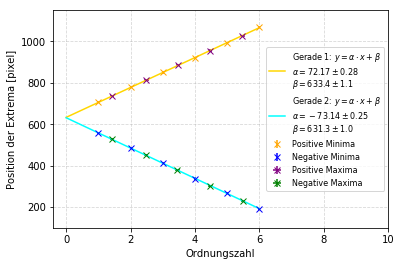

In [8]:
plt.grid(alpha=0.5, linestyle='--')
plt.axis([-0.4, 10, 100, 1150])
plt.ylabel('Position der Extrema [pixel]')
plt.xlabel('Ordnungszahl')
plt.errorbar(ordn_s_min, s_p_min, yerr=dpixel_min, fmt='x', color='orange', label='Positive Minima')
plt.errorbar(ordn_s_min, s_n_min, yerr=dpixel_min, fmt='x', color='blue', label='Negative Minima')
plt.errorbar(ordn_s_p_max_theo, s_p_max, yerr=dpixel_max, xerr=dordn_s_p_max_theo, fmt='x', color='purple', label='Positive Maxima')
plt.errorbar(ordn_s_n_max_theo, s_n_max, yerr=dpixel_max, xerr=dordn_s_n_max_theo, fmt='x', color='green', label='Negative Maxima')
plt.plot(x, linear(x, *opt_s_p_min), color='gold',
        label="\n".join([r"Gerade 1: $y = \alpha \cdot x + \beta$", 
                          r'$\alpha ={:.2f}\pm{:.2}$'.format(opt_s_p_min[0], np.sqrt(cov_s_p_min[0][0])), 
                          r'$\beta ={:.1f}\pm{:.2}$'.format(opt_s_p_min[1], np.sqrt(cov_s_p_min[1][1]))]))
plt.plot(x, linear(x, *opt_s_n_min), color='cyan',
        label="\n".join([r"Gerade 2: $y = \alpha \cdot x + \beta$", 
                          r'$\alpha ={:.2f}\pm{:.2}$'.format(opt_s_n_min[0], np.sqrt(cov_s_n_min[0][0])), 
                          r'$\beta ={:.1f}\pm{:.1f}$'.format(opt_s_n_min[1], np.sqrt(cov_s_n_min[1][1]))]))
plt.legend(loc='center right',prop={'size': 8})
plt.savefig('./output/Position-Ordnungszahl-Min+Max.pdf', format='PDF')

In [9]:
#Tabelle
head1=['Nr.', 'pos', 'x', 'neg', 'x']
tab1 = zip(np.arange(1,6), np.round(ordn_s_p_max_theo, 2), np.round(dordn_s_p_max_theo, 2), np.round(ordn_s_n_max_theo, 2), np.round(dordn_s_n_max_theo, 2))

print(tabulate(tab1, headers=head1, tablefmt="latex"))

\begin{tabular}{rrrrr}
\hline
   Nr. &   pos &    x &   neg &    x \\
\hline
     1 &  1.42 & 0.07 &  1.43 & 0.07 \\
     2 &  2.49 & 0.07 &  2.48 & 0.07 \\
     3 &  3.47 & 0.07 &  3.45 & 0.07 \\
     4 &  4.47 & 0.07 &  4.48 & 0.07 \\
     5 &  5.47 & 0.07 &  5.49 & 0.07 \\
\hline
\end{tabular}


In [10]:
head2 = ['Nr.', 'n', 'x', 'lit', 'sig']
tab2 = zip(np.arange(1,6), np.round(ordn_s_max_theo, 2), np.round(dordn_s_max_theo, 2), ordn_Maxima, np.round(sigma_ordn_s_max, 2))

print(tabulate(tab2, headers=head2, tablefmt="latex"))

\begin{tabular}{rrrrr}
\hline
   Nr. &    n &    x &   lit &   sig \\
\hline
     1 & 1.42 & 0.07 &   1.5 &  1.08 \\
     2 & 2.48 & 0.07 &   2.5 &  0.23 \\
     3 & 3.46 & 0.07 &   3.5 &  0.54 \\
     4 & 4.47 & 0.07 &   4.5 &  0.38 \\
     5 & 5.48 & 0.07 &   5.5 &  0.31 \\
\hline
\end{tabular}


---

In [11]:
#Intensitätsverhältnisse:
inten_0_1_p = (47-9)/(924-9) #nulltes zum ersten maximum
inten_0_1_n = (49-9)/(924-9)
dinten_0_1_p = inten_0_1_p * np.sqrt((5/(47-9))**2 + (5/(924-9))**2) 
dinten_0_1_n = inten_0_1_n * np.sqrt((5/(49-9))**2 + (5/(924-9))**2) 

inten_s_p = np.array([832, 324, 177, 121, 77]) - 9 #Nebenmax 1-5
inten_s_n = np.array([871, 320, 171, 101, 73]) - 9

inten_rel_s_p = np.full(5, inten_0_1_p)
inten_rel_s_n = np.full(5, inten_0_1_n)
dinten_rel_s_p = np.full(5, dinten_0_1_p)
dinten_rel_s_n = np.full(5, dinten_0_1_n)

for i in np.arange(0,4):
    inten_rel_s_p[i+1] = inten_0_1_p * inten_s_p[i+1]/inten_s_p[0]
    inten_rel_s_n[i+1] = inten_0_1_n * inten_s_n[i+1]/inten_s_n[0]
    dinten_rel_s_p[i+1] = inten_rel_s_p[i+1] * np.sqrt((dinten_0_1_p/inten_0_1_p)**2 + (5/inten_s_p[i+1])**2 + (5/inten_s_p[0])**2)
    dinten_rel_s_n[i+1] = inten_rel_s_n[i+1] * np.sqrt((dinten_0_1_n/inten_0_1_n)**2 + (5/inten_s_n[i+1])**2 + (5/inten_s_n[0])**2)

inten_rel_s = np.empty(5)
dinten_rel_s = np.empty(5)

for i in np.arange(0,5):
    inten_rel_s[i] = np.mean([inten_rel_s_p[i], inten_rel_s_n[i]])
    dinten_rel_s[i] = np.sqrt((np.std([inten_rel_s_p[i], inten_rel_s_n[i]], ddof=1)/np.sqrt(2))**2 + (0.5 * (dinten_rel_s_p[i] + dinten_rel_s_n[i]))**2)

print(inten_rel_s_p) # verhältnisse von 1-5. nebenmaximum zum 0. Maximum
print(dinten_rel_s_p)
print(inten_rel_s_n)
print(dinten_rel_s_n)
print('Mean:', inten_rel_s)
print('Err.:', dinten_rel_s)

[0.04153005 0.01589546 0.00847758 0.00565172 0.0034314 ]
[0.00546919 0.00211067 0.00114575 0.00078664 0.00051798]
[0.04371585 0.01577219 0.00821574 0.00466573 0.00324572]
[0.0054697  0.00199173 0.00105983 0.00063704 0.00047914]
Mean: [0.04262295 0.01583383 0.00834666 0.00515872 0.00333856]
Err.: [0.00557757 0.00205213 0.00111053 0.00086589 0.00050713]


In [12]:
#Theoretische Verhältnisse:
def max_sinc(n):
    return (n + 0.5) * np.pi - 1/((n + 0.5) * np.pi)

maxima_pos_lit = max_sinc(np.arange(1,6))

inten_s_theo = np.sin(maxima_pos_lit)**2 /(maxima_pos_lit**2)

print(inten_s_theo)

[0.04718829 0.01647999 0.00834029 0.00502872 0.00336073]


In [13]:
#Signifikanztests:
sign_inten_s = np.abs(inten_s_theo - inten_rel_s)/dinten_rel_s
print(sign_inten_s)

[0.8185174  0.31487586 0.00573562 0.15014182 0.0437106 ]


In [14]:
#Tabellen:
head_A2_1 = ['nr.', 'rel pos', 'err', 'rel neg', 'err', 'mean', 'err']
tab_A2_1 = zip(np.arange(1,6), np.round(inten_rel_s_p, 4), np.round(dinten_rel_s_p, 4), np.round(inten_rel_s_n, 4), np.round(dinten_rel_s_n, 4), np.round(inten_rel_s, 4), np.round(dinten_rel_s, 4))

print(tabulate(tab_A2_1, headers=head_A2_1, tablefmt="latex"))

\begin{tabular}{rrrrrrr}
\hline
   nr. &   rel pos &    err &   rel neg &    err &   mean &    err \\
\hline
     1 &    0.0415 & 0.0055 &    0.0437 & 0.0055 & 0.0426 & 0.0056 \\
     2 &    0.0159 & 0.0021 &    0.0158 & 0.002  & 0.0158 & 0.0021 \\
     3 &    0.0085 & 0.0011 &    0.0082 & 0.0011 & 0.0083 & 0.0011 \\
     4 &    0.0057 & 0.0008 &    0.0047 & 0.0006 & 0.0052 & 0.0009 \\
     5 &    0.0034 & 0.0005 &    0.0032 & 0.0005 & 0.0033 & 0.0005 \\
\hline
\end{tabular}


In [15]:
head_A2_2 = ['nr.', 'meas', 'err', 'theo', 'sigma']
tab_A2_2 = zip(np.arange(1,6), np.round(inten_rel_s, 4), np.round(dinten_rel_s, 4), inten_s_theo, np.round(sign_inten_s, 2))

print(tabulate(tab_A2_2, headers=head_A2_2, tablefmt="latex"))

\begin{tabular}{rrrrr}
\hline
   nr. &   meas &    err &       theo &   sigma \\
\hline
     1 & 0.0426 & 0.0056 & 0.0471883  &    0.82 \\
     2 & 0.0158 & 0.0021 & 0.01648    &    0.31 \\
     3 & 0.0083 & 0.0011 & 0.00834029 &    0.01 \\
     4 & 0.0052 & 0.0009 & 0.00502872 &    0.15 \\
     5 & 0.0033 & 0.0005 & 0.00336073 &    0.04 \\
\hline
\end{tabular}


# Beugungsbilder Doppelspalt - A3

Benennung:

Pixel/Intensität (p/i) - Einzelspalt/Doppelspalt (s/d) - Objektbild/Beugungsbild (o/b) - Typ

Bsp.: Beugungsbild Doppelspalt Pixelwerte: 'p_d_b' 

2.475374732334047


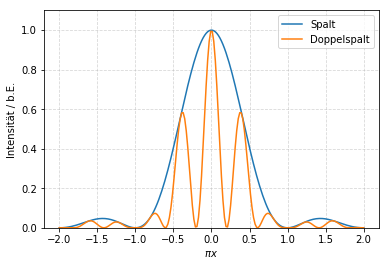

In [16]:
def beugung_spalt(x):
    return np.sinc(x)**2

def beugung_doppelspalt(x):
    return np.sinc(x)**2*np.cos(np.pi*v*x)**2

#Anzahl a der Nebenmaxima die dargestellt werden sollen:
a=1
#Verhaeltnis Spaltabstand zu Spaltbreite:
v=578/np.mean([246, 221])
print(v)

x=np.linspace(-(a+1),a+1,200)
plt.plot(x,beugung_spalt(x),label='Spalt')
plt.grid(alpha=0.5, linestyle='--')
plt.plot(x,beugung_doppelspalt(x),label='Doppelspalt')
plt.xlabel('$\pi x$')
plt.ylabel('Intensität / b.E.')
plt.ylim((0,1.1))
plt.legend()
plt.savefig("./output/Beugung_spalt_doppelspalt_Theo.pdf", format="pdf")

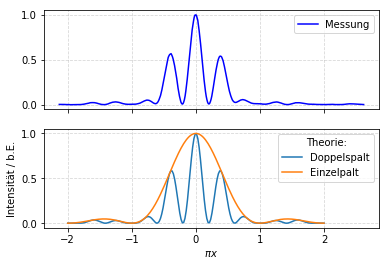

In [17]:
p_d_b, i_d_b = np.loadtxt('./doppelspalt beugung.txt', skiprows=3, unpack=True)


fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
plt.xlabel('$\pi x$')
plt.ylabel('Intensität / b.E.')
ax1.plot((p_d_b-194)/(285-194), ((i_d_b-9)/(773-9)), color='blue', label='Messung')
ax2.plot(x,beugung_doppelspalt(x),label='Doppelspalt')
ax2.plot(x,beugung_spalt(x),label='Einzelpalt')
ax1.grid(alpha=0.5, linestyle='--')
ax2.grid(alpha=0.5, linestyle='--')
ax1.legend()
ax2.legend(title='Theorie:')
plt.savefig("./output/Beugung_spalt_doppelspalt_Vergleich.pdf", format="pdf")

In [18]:
#Relative Intensitäten - Messung:
inten_d_0 = 773 - 9
inten_d_p = np.array([423, 52]) - 9
inten_d_n = np.array([441, 47]) - 9


inten_rel_d_p = np.empty(2)
inten_rel_d_n = np.empty(2)
dinten_rel_d_p = np.empty(2)
dinten_rel_d_n = np.empty(2)

for i in np.arange(0,2):
    inten_rel_d_p[i] = inten_d_p[i]/inten_d_0
    inten_rel_d_n[i] = inten_d_n[i]/inten_d_0
    dinten_rel_d_p[i] = inten_rel_d_p[i] * np.sqrt((5/inten_d_p[i])**2 + (5/inten_d_0)**2)
    dinten_rel_d_n[i] = inten_rel_d_n[i] * np.sqrt((5/inten_d_n[i])**2 + (5/inten_d_0)**2)
    
print(inten_rel_d_p)
print(dinten_rel_d_p)
print(inten_rel_d_n)
print(dinten_rel_d_n)

inten_rel_d = np.empty(2)
dinten_rel_d = np.empty(2)

for i in np.arange(0,2):
    inten_rel_d[i] = np.mean([inten_rel_d_p[i], inten_rel_d_n[i]])
    dinten_rel_d[i] = np.sqrt((np.std([inten_rel_d_p[i], inten_rel_d_n[i]], ddof=1)/np.sqrt(2))**2 + (0.5 * (dinten_rel_d_p[i] + dinten_rel_d_n[i]))**2)

print('Mean:', inten_rel_d)
print('Err.:', dinten_rel_d)

[0.54188482 0.05628272]
[0.0074436  0.00655486]
[0.56544503 0.04973822]
[0.00751829 0.00655259]
Mean: [0.55366492 0.05301047]
Err.: [0.01395476 0.00732523]


[0.38190955 0.74371859]
[0.58576775 0.07335671]


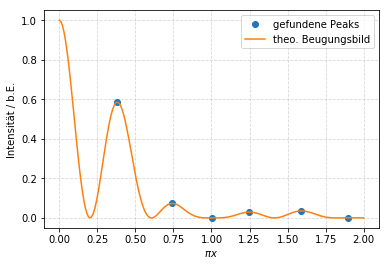

In [19]:
#Relative Intensitäten - Theorie:
x_half=np.linspace(0,a+1,200)
peakind = signal.find_peaks_cwt(beugung_doppelspalt(x_half), np.arange(0.1,2), noise_perc=10)
plt.grid(alpha=0.5, linestyle='--')
plt.plot(x_half[peakind], beugung_doppelspalt(x_half)[peakind],marker='o', linewidth=0, label='gefundene Peaks')
plt.plot(x_half,beugung_doppelspalt(x_half), label='theo. Beugungsbild')
plt.xlabel('$\pi x$')
plt.ylabel('Intensität / b.E.')
plt.legend()
plt.savefig("./output/Beugung_doppelspalt_Theo_Peaks.pdf", format="pdf")


pos_theo = x_half[peakind]
inten_theo = beugung_doppelspalt(x_half)[peakind]

print(pos_theo[:2])
print(inten_theo[:2])

In [20]:
#Signifikanztest:
sigma_inten_rel_d = np.abs(inten_rel_d - inten_theo[:2])/dinten_rel_d

print(sigma_inten_rel_d)

[2.30049227 2.77755702]


# Modifizierte Objektbilder

In [21]:
d1 = 249 #Spaltbreite Einzelspalt
d2 = np.mean([246, 221]) #Spaltbreite Doppelspalt
g=v*d2 #Spaltabstand in Einheiten der Spaltbreite

#Integrand
def spalt(k,y):
    return d1/np.pi*np.sin(k*d1/2)/(k*d1/2)*np.cos(y*k)

def doppelspalt(k, y):
    return d2/np.pi*np.cos(k*g/2)*np.sin(k*d2/2)/(k*d2/2)*np.cos(y*k)

def doppel_mod(x):
    Y=np.linspace(-2,2,200)*d2
    f_modifiziert=[]
    for i in range(len(Y)):
        y=Y[i]
        result, error = quad(doppelspalt, 0, 2*np.pi*x/d2, args =(y,))
        f_modifiziert.append(result**2)
    f_modifiziert = f_modifiziert/np.max(f_modifiziert)
    return Y, f_modifiziert

def single_mod(x):
    Y=np.linspace(-1,1,200)*d1
    f_modifiziert=[]
    for i in range(len(Y)):
        y=Y[i]
        result, error = quad(spalt, 0, 2*np.pi*x/d1, args =(y,))
        f_modifiziert.append(result**2)
    f_modifiziert = f_modifiziert/np.max(f_modifiziert)
    return Y, f_modifiziert

---

# Aufgabe 4 - Analyse Objektbild Einzelspalt

### Einzelspalt Bilder - Theorie

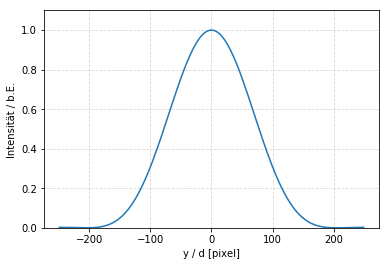

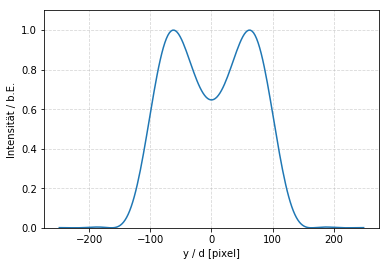

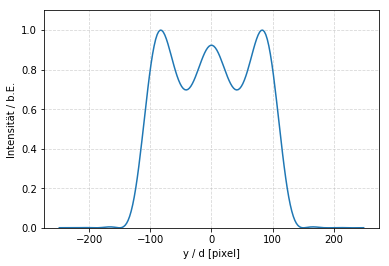

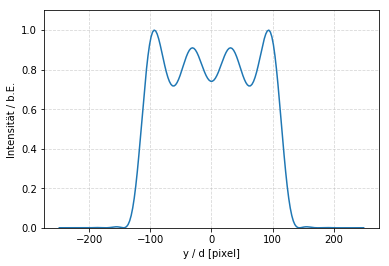

In [22]:
for i in range(1,5):
    x, y = single_mod(i)
    plt.figure()
    plt.plot(x, y)
    plt.grid(alpha=0.5, linestyle='--')
    plt.xlabel('y / d [pixel]')
    plt.ylabel('Intensität / b.E.')
    plt.ylim((0,1.1))
    plt.savefig("output/Theo_Obj_Einzelspalt_%03d.pdf"%(i), format="pdf")

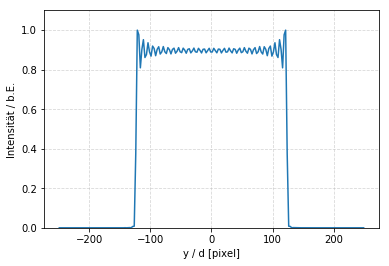

In [23]:
# Viele Ordnungen Zugelassen:
x, y = single_mod(30)
plt.figure()
plt.plot(x, y)
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel('y / d [pixel]')
plt.ylabel('Intensität / b.E.')
plt.ylim((0,1.1))
plt.savefig("output/Theo_Obj_Einzelspalt_999.pdf", format="pdf")

---

In [24]:
def PltMessung1(source, i):
    x, y = np.loadtxt(source, skiprows=3, unpack=True)
    plt.figure()
    plt.plot(x, y)
    plt.grid(alpha=0.5, linestyle='--')
    plt.ylim(0,1000)
    plt.xlabel('pixel')
    plt.ylabel('Intensität')
    plt.savefig("output/Messung_Obj_Einzelspalt_%03d.pdf"%(i), format="pdf")

### Einzelspalt Blider - Messung

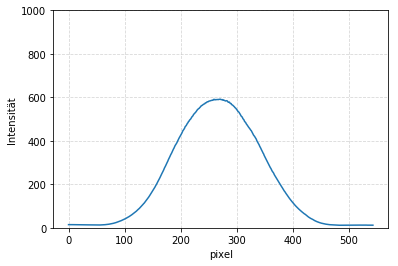

In [25]:
PltMessung1('./obj_single/obj_einzelspalt_0_inten.txt', 0)

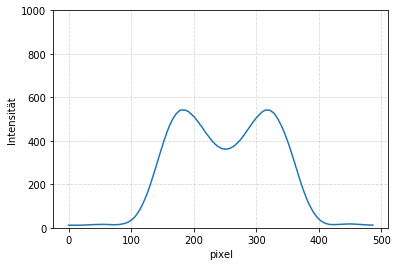

In [26]:
PltMessung1('./obj_single/obj_einzelspalt_0+1_inten.txt', 1)

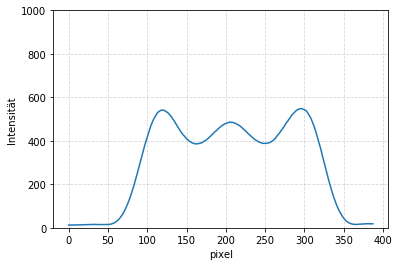

In [27]:
PltMessung1('./obj_single/obj_einzelspalt_0+1+2_inten.txt', 2)

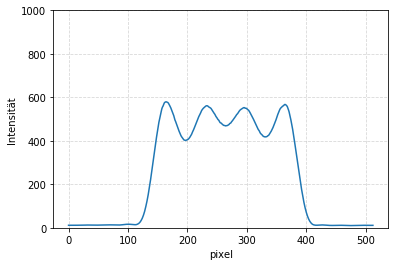

In [28]:
PltMessung1('./obj_single/obj_einzelspalt_0+1+2+3_inten.txt', 3)

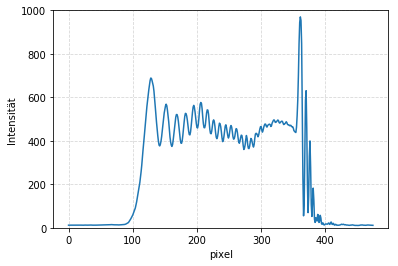

In [29]:
PltMessung1('./obj_single/obj_einzelspalt_full_inten.txt', 999)

---

### Einzelspalt Bilder - Normierung

In [30]:
norm_inten = 592 #intensität des maximums der Messung bei nur 0. ordnung
norm_pos_0 = 268 #x-Position des Maximums (0.Ordn)
norm_pos_1 = 250 #x-Pos (0. + 1. Ordn)
norm_pos_2 = 206 #...
norm_pos_3 = 265
norm_pos_full = 250


def PltNorm(source, pos, i):
    x, y = np.loadtxt(source, skiprows=3, unpack=True)
    plt.figure()
    plt.plot(x-pos, y/norm_inten)
    plt.grid(alpha=0.5, linestyle='--')
    plt.xlabel('norm. pixel')
    plt.ylabel('norm. Intensität')
    plt.ylim(0,1.2)
    plt.savefig("output/Normierung_Obj_Einzelspalt_%03d.pdf"%(i), format="pdf")
    
def NormPeaks(source):
    x, y = np.loadtxt(source, skiprows=3, unpack=True)
    peaks, _ = signal.find_peaks(y/norm_inten, height=0.5, distance=10, width=20)
    print(y[peaks]/norm_inten)
    return y[peaks]/norm_inten

def NormPeaks_Minima(source):
    x, y = np.loadtxt(source, skiprows=3, unpack=True)
    peaks, _ = signal.find_peaks(-y/norm_inten, height=[-1, -0.5], distance=10, width=20)
    print(y[peaks]/norm_inten)
    return y[peaks]/norm_inten

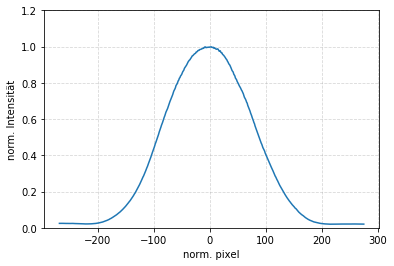

In [31]:
PltNorm('./obj_single/obj_einzelspalt_0_inten.txt', norm_pos_0, 0)

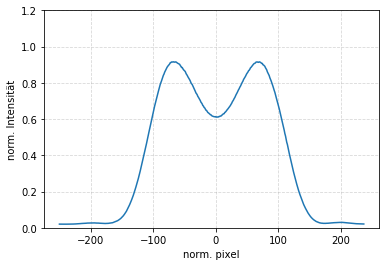

In [32]:
PltNorm('./obj_single/obj_einzelspalt_0+1_inten.txt', norm_pos_1, 1)

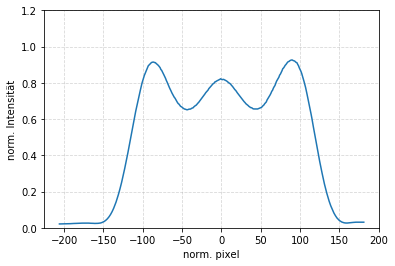

In [33]:
PltNorm('./obj_single/obj_einzelspalt_0+1+2_inten.txt', norm_pos_2, 2)

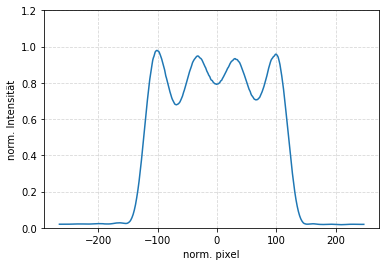

In [34]:
PltNorm('./obj_single/obj_einzelspalt_0+1+2+3_inten.txt', norm_pos_3, 3)

---

### Intensitätsvergleich

In [35]:
# Intensitäten Messungen:
inten_s_obj_max_0 = NormPeaks('./obj_single/obj_einzelspalt_0_inten.txt')

inten_s_obj_max_1 = NormPeaks('./obj_single/obj_einzelspalt_0+1_inten.txt')
inten_s_obj_min_1 = NormPeaks_Minima('./obj_single/obj_einzelspalt_0+1_inten.txt')

inten_s_obj_max_2 = NormPeaks('./obj_single/obj_einzelspalt_0+1+2_inten.txt')
inten_s_obj_min_2 = NormPeaks_Minima('./obj_single/obj_einzelspalt_0+1+2_inten.txt')

inten_s_obj_max_3 = NormPeaks('./obj_single/obj_einzelspalt_0+1+2+3_inten.txt')
inten_s_obj_min_3 = NormPeaks_Minima('./obj_single/obj_einzelspalt_0+1+2+3_inten.txt')

#Fehlerabschätzung (Ablesegenauigkeit):
dinten_s_obj = 0.03

[0.99895142]
[0.91612828 0.91574372]
[0.61083517]
[0.91449782 0.82248198 0.92619706]
[0.65147851 0.65513843]
[0.97918218 0.94803916 0.93349941 0.95843356]
[0.67894586 0.79175402 0.7060684 ]


In [36]:
# Intensitäten Theorie:
def TheoPeaks(i):
    x, y = single_mod(i)
    peaks, _ = signal.find_peaks(y, height=0.5, width=0.05)
    print(y[peaks])
    return y[peaks]

def TheoPeaks_Minima(i):
    x, y = single_mod(i)
    peaks, _ = signal.find_peaks(-y, height=[-1, -0.5], width=0.05)
    print(y[peaks])
    return y[peaks]

inten_s_obj_max_0_theo = TheoPeaks(1)

inten_s_obj_max_1_theo = TheoPeaks(2)
inten_s_obj_min_1_theo = TheoPeaks_Minima(2)

inten_s_obj_max_2_theo = TheoPeaks(3)
inten_s_obj_min_2_theo = TheoPeaks_Minima(3)

inten_s_obj_max_3_theo = TheoPeaks(4)
inten_s_obj_min_3_theo = TheoPeaks_Minima(4)

[1.]
[1. 1.]
[0.64726074]
[1.         0.92316817 1.        ]
[0.69734819 0.69734819]
[1.         0.91044864 0.91044864 1.        ]
[0.71744022 0.74130956 0.71744022]


In [37]:
#Ordnung:
inten_s_obj_max = np.concatenate((inten_s_obj_max_0, inten_s_obj_max_1, inten_s_obj_max_2, inten_s_obj_max_3), axis=0)
inten_s_obj_min = np.concatenate((inten_s_obj_min_1, inten_s_obj_min_2, inten_s_obj_min_3), axis=0)

inten_s_obj_max_theo = np.concatenate((inten_s_obj_max_0_theo, inten_s_obj_max_1_theo, inten_s_obj_max_2_theo, inten_s_obj_max_3_theo), axis=0)
inten_s_obj_min_theo = np.concatenate((inten_s_obj_min_1_theo, inten_s_obj_min_2_theo, inten_s_obj_min_3_theo), axis=0)

In [38]:
#Signifikanztests:
sigma_inten_s_obj_max = np.abs(inten_s_obj_max-inten_s_obj_max_theo)/dinten_s_obj
sigma_inten_s_obj_min = np.abs(inten_s_obj_min-inten_s_obj_min_theo)/dinten_s_obj

print(sigma_inten_s_obj_max)
print(sigma_inten_s_obj_min)

[0.0349527  2.7957241  2.80854279 2.85007264 3.35620662 2.46009797
 0.69392736 1.25301712 0.7683589  1.38554786]
[1.21418555 1.52898917 1.40699199 1.28314529 1.68148192 0.37906083]


In [39]:
#Tabelle Maxima:
head_A4_1 = ['Ordn.', 'I_meas', 'x', 'I_theo', 'sigma']
tab_A4_1 = zip(np.array([0, 1, 1, 2, 2, 2, 3, 3, 3, 3]),
              np.round(inten_s_obj_max, 2), np.full(10, dinten_s_obj),
              np.round(inten_s_obj_max_theo, 4), np.round(sigma_inten_s_obj_max, 2))

print(tabulate(tab_A4_1, headers=head_A4_1, tablefmt="latex"))

\begin{tabular}{rrrrr}
\hline
   Ordn. &   I\_meas &    x &   I\_theo &   sigma \\
\hline
       0 &     1    & 0.03 &   1      &    0.03 \\
       1 &     0.92 & 0.03 &   1      &    2.8  \\
       1 &     0.92 & 0.03 &   1      &    2.81 \\
       2 &     0.91 & 0.03 &   1      &    2.85 \\
       2 &     0.82 & 0.03 &   0.9232 &    3.36 \\
       2 &     0.93 & 0.03 &   1      &    2.46 \\
       3 &     0.98 & 0.03 &   1      &    0.69 \\
       3 &     0.95 & 0.03 &   0.9104 &    1.25 \\
       3 &     0.93 & 0.03 &   0.9104 &    0.77 \\
       3 &     0.96 & 0.03 &   1      &    1.39 \\
\hline
\end{tabular}


In [40]:
#Tabelle Minima:
head_A4_2 = ['Ordn.', 'I_meas', 'x', 'I_theo', 'sigma']
tab_A4_2 = zip(np.array([1, 2, 2, 3, 3, 3]),
              np.round(inten_s_obj_min, 2), np.full(10, dinten_s_obj),
              np.round(inten_s_obj_min_theo, 4), np.round(sigma_inten_s_obj_min, 2))

print(tabulate(tab_A4_2, headers=head_A4_2, tablefmt="latex"))

\begin{tabular}{rrrrr}
\hline
   Ordn. &   I\_meas &    x &   I\_theo &   sigma \\
\hline
       1 &     0.61 & 0.03 &   0.6473 &    1.21 \\
       2 &     0.65 & 0.03 &   0.6973 &    1.53 \\
       2 &     0.66 & 0.03 &   0.6973 &    1.41 \\
       3 &     0.68 & 0.03 &   0.7174 &    1.28 \\
       3 &     0.79 & 0.03 &   0.7413 &    1.68 \\
       3 &     0.71 & 0.03 &   0.7174 &    0.38 \\
\hline
\end{tabular}


---

# A5 - Analyse Objektbild Doppelspalt

### Doppelspalt Bilder - Theorie - A5

[1. 1.]
[]
[1.         0.99744101 0.99744101 1.        ]
[0.65745344 0.65745344]
[0.99916997 0.92507016 1.         1.         0.92507016 0.99916997]
[0.69325885 0.69107118 0.69107118 0.69325885]
[1.         0.91097535 0.91064878 0.99606185 0.99606185 0.91064878
 0.91097535 1.        ]
[0.7251521  0.74651666 0.72544417 0.72544417 0.74651666 0.7251521 ]


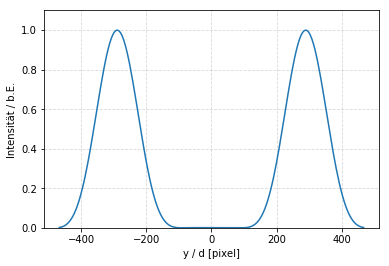

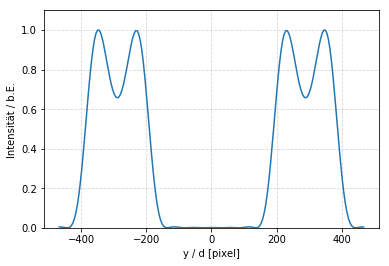

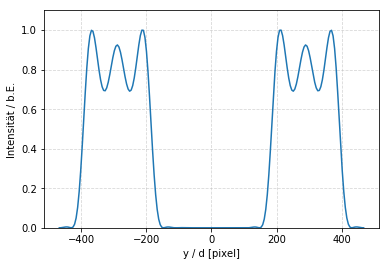

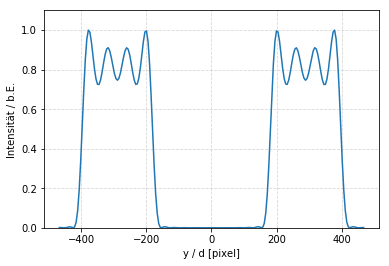

In [41]:
inten_d_obj_max_theo = np.array([])
inten_d_obj_min_theo = np.array([])

for i in range(1,5):
    x, y = doppel_mod(i)
    plt.figure()
    plt.plot(x, y)
    plt.grid(alpha=0.5, linestyle='--')
    plt.xlabel('y / d [pixel]')
    plt.ylabel('Intensität / b.E.')
    plt.ylim((0,1.1))
    peaks, _ = signal.find_peaks(y, height=0.5, width=0.05)
    print(y[peaks])
    inten_d_obj_max_theo = np.append(inten_d_obj_max_theo, y[peaks], axis=0)
    peaks_, __ = signal.find_peaks(-y, height=[-1,-0.5], width=0.05)
    print(y[peaks_])
    inten_d_obj_min_theo = np.append(inten_d_obj_min_theo, y[peaks_], axis=0)
    plt.savefig("output/Theo_Obj_Doppelspalt_%03d.pdf"%(i), format="pdf")

In [42]:
print(inten_d_obj_max_theo)
print(inten_d_obj_min_theo)

[1.         1.         1.         0.99744101 0.99744101 1.
 0.99916997 0.92507016 1.         1.         0.92507016 0.99916997
 1.         0.91097535 0.91064878 0.99606185 0.99606185 0.91064878
 0.91097535 1.        ]
[0.65745344 0.65745344 0.69325885 0.69107118 0.69107118 0.69325885
 0.7251521  0.74651666 0.72544417 0.72544417 0.74651666 0.7251521 ]


---

In [43]:
def PltMessung2(source, i):
    x, y = np.loadtxt(source, skiprows=3, unpack=True)
    plt.figure()
    plt.plot(x, y)
    plt.grid(alpha=0.5, linestyle='--')
    plt.ylim(0,1200)
    plt.xlabel('pixel')
    plt.ylabel('Intensität')
    plt.savefig("output/Messung_Obj_Doppelspalt_%03d.pdf"%(i), format="pdf")

### Doppelspalt Bilder - Messung

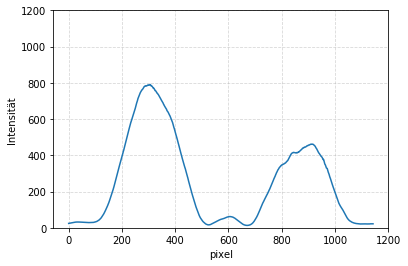

In [44]:
PltMessung2('./obj_doppel/objektbild_doppelspalt_0_inten.txt', 0)

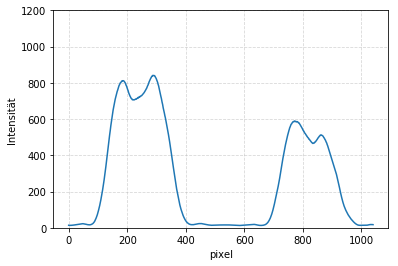

In [45]:
PltMessung2('./obj_doppel/objektbild_doppelspalt_0_1_inten.txt', 1)

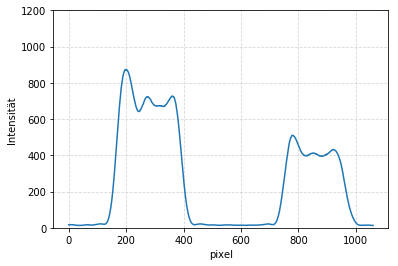

In [46]:
PltMessung2('./obj_doppel/objektbild_doppelspalt_0_1_2_inten.txt', 2)

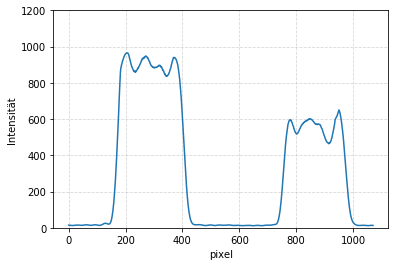

In [47]:
PltMessung2('./obj_doppel/objektbild_doppelspalt_0_1_2_3_inten.txt', 3)

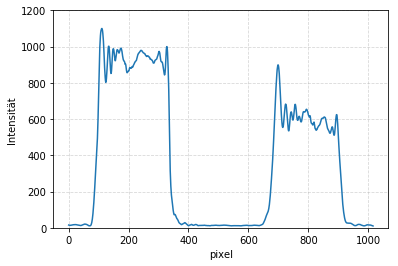

In [48]:
PltMessung2('./obj_doppel/objektbild_doppelspalt_full_inten.txt', 999)

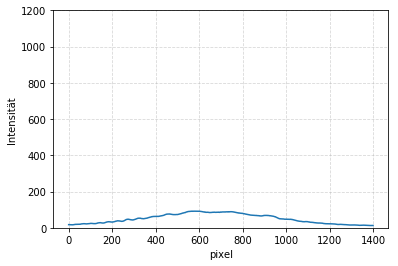

In [49]:
PltMessung2('./obj_doppel/objektbild_doppelspalt_plateau_inten.txt', 998)

### Doppelspalt Bilder - Normierung

In [50]:
norm_xPos_d = np.array([600, 545, 575, 585])
norm_inten_d = np.array([792, 840, 873, 964]) #inten peak links bei 0. ordn

inten_d_obj_max = np.array([])
inten_d_obj_min = np.array([])

def PltNorm2(source, i):
    global inten_d_obj_max, inten_d_obj_min
    x, y = np.loadtxt(source, skiprows=3, unpack=True)
    plt.figure()
    plt.plot(x-norm_xPos_d[i], y/norm_inten_d[i])
    plt.grid(alpha=0.5, linestyle='--')
    plt.ylim(0,1.1)
    plt.xlabel('pixel')
    plt.ylabel('Norm. Intensität')
    peaks, _ = signal.find_peaks(y/norm_inten_d[i], height=0.4, width=10)
    print(y[peaks]/norm_inten_d[i])
    inten_d_obj_max = np.append(inten_d_obj_max, y[peaks]/norm_inten_d[i], axis=0)
    peaks_, __ = signal.find_peaks(-y/norm_inten_d[i], height=[-1.3,-0.4], width=10)
    print(y[peaks_]/norm_inten_d[i])
    inten_d_obj_min = np.append(inten_d_obj_min, y[peaks_]/norm_inten_d[i], axis=0)
    plt.scatter(x[peaks]-norm_xPos_d[i], y[peaks]/norm_inten_d[i], marker='x', color='green', label='gefundene Maxima')
    plt.scatter(x[peaks_]-norm_xPos_d[i], y[peaks_]/norm_inten_d[i], marker='x', color='blue', label='gefundene Minima')
    plt.legend(loc='upper right')
    plt.savefig("output/Normierung_Obj_Doppelspalt_%03d.pdf"%(i), format="pdf")

[0.998389   0.58301914]
[]


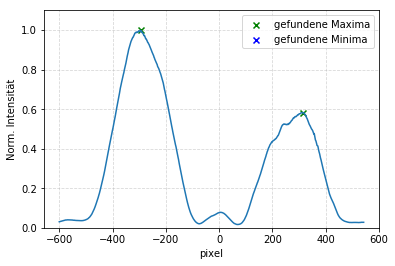

In [51]:
PltNorm2('./obj_doppel/objektbild_doppelspalt_0_inten.txt', 0)

[0.96635725 1.00164939 0.7002759  0.61029917]
[0.8404459  0.55438568]


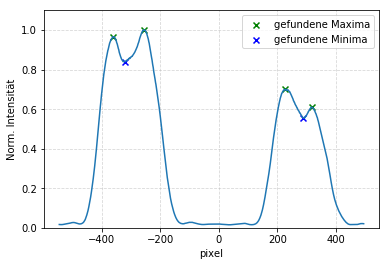

In [52]:
PltNorm2('./obj_doppel/objektbild_doppelspalt_0_1_inten.txt', 1)

[1.00071008 0.82901399 0.83360157 0.58462457 0.47341961 0.49476213]
[0.73495609 0.76692273 0.45452903 0.45197806]


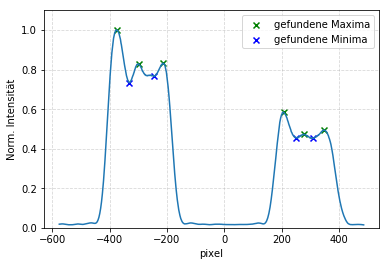

In [53]:
PltNorm2('./obj_doppel/objektbild_doppelspalt_0_1_2_inten.txt', 2)

[1.0019107  0.98351482 0.93094517 0.97518641 0.61865618 0.62386526
 0.67429614]
[0.89012288 0.91565137 0.86646348 0.53631404 0.4816906 ]


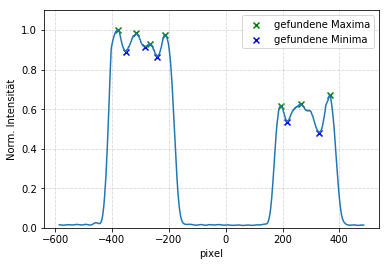

In [54]:
PltNorm2('./obj_doppel/objektbild_doppelspalt_0_1_2_3_inten.txt', 3)

In [55]:
print(inten_d_obj_max)
print(inten_d_obj_min)
#len(inten_d_obj_min)
inten_d_obj_max = np.insert(inten_d_obj_max, 18, None)
inten_d_obj_min = np.insert(inten_d_obj_min, 10, None)
print(inten_d_obj_max)
print(inten_d_obj_min)

[0.998389   0.58301914 0.96635725 1.00164939 0.7002759  0.61029917
 1.00071008 0.82901399 0.83360157 0.58462457 0.47341961 0.49476213
 1.0019107  0.98351482 0.93094517 0.97518641 0.61865618 0.62386526
 0.67429614]
[0.8404459  0.55438568 0.73495609 0.76692273 0.45452903 0.45197806
 0.89012288 0.91565137 0.86646348 0.53631404 0.4816906 ]
[0.998389   0.58301914 0.96635725 1.00164939 0.7002759  0.61029917
 1.00071008 0.82901399 0.83360157 0.58462457 0.47341961 0.49476213
 1.0019107  0.98351482 0.93094517 0.97518641 0.61865618 0.62386526
        nan 0.67429614]
[0.8404459  0.55438568 0.73495609 0.76692273 0.45452903 0.45197806
 0.89012288 0.91565137 0.86646348 0.53631404        nan 0.4816906 ]


In [56]:
#Sigmas:
sigma_inten_d_max = np.abs(inten_d_obj_max-inten_d_obj_max_theo)/dinten_s_obj
sigma_inten_d_min = np.abs(inten_d_obj_min-inten_d_obj_min_theo)/dinten_s_obj

print(sigma_inten_d_max)
print(sigma_inten_d_min)

[ 0.05369992 13.89936195  1.121425    0.14027932  9.90550362 12.99002778
  0.05133693  3.20187247  5.54661436 13.84584765 15.05501832 16.81359472
  0.06368983  2.41798261  0.67654628  0.69584799 12.58018893  9.55945061
         nan 10.8567953 ]
[6.09974892 3.43559196 1.38990827 2.52838488 7.88473845 8.04269272
 5.49902617 5.63782362 4.70064346 6.30433786        nan 8.11538323]


In [57]:
#Tabelle Maxima:
head_a5_max = ['Nr.', 'Theo', 'Norm Messwert Maxima', 'x', 'sigma']
tab_a5_max = zip(np.array([0,0,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,3,3]), np.round(inten_d_obj_max_theo, 4), np.round(inten_d_obj_max, 4), np.full(20, dinten_s_obj), np.round(sigma_inten_d_max, 2))

print(tabulate(tab_a5_max, headers=head_a5_max, tablefmt="latex"))

\begin{tabular}{rrrrr}
\hline
   Nr. &   Theo &   Norm Messwert Maxima &    x &   sigma \\
\hline
     0 & 1      &                 0.9984 & 0.03 &    0.05 \\
     0 & 1      &                 0.583  & 0.03 &   13.9  \\
     1 & 1      &                 0.9664 & 0.03 &    1.12 \\
     1 & 0.9974 &                 1.0016 & 0.03 &    0.14 \\
     1 & 0.9974 &                 0.7003 & 0.03 &    9.91 \\
     1 & 1      &                 0.6103 & 0.03 &   12.99 \\
     2 & 0.9992 &                 1.0007 & 0.03 &    0.05 \\
     2 & 0.9251 &                 0.829  & 0.03 &    3.2  \\
     2 & 1      &                 0.8336 & 0.03 &    5.55 \\
     2 & 1      &                 0.5846 & 0.03 &   13.85 \\
     2 & 0.9251 &                 0.4734 & 0.03 &   15.06 \\
     2 & 0.9992 &                 0.4948 & 0.03 &   16.81 \\
     3 & 1      &                 1.0019 & 0.03 &    0.06 \\
     3 & 0.911  &                 0.9835 & 0.03 &    2.42 \\
     3 & 0.9106 &                 0.9309 & 0.03 

In [58]:
#Tabelle Minima:
head_a5_min = ['Nr.', 'Theo', 'Norm Messwert Minima', 'x', 'sigma']
tab_a5_min = zip(np.array([1,1,2,2,2,2,3,3,3,3,3,3]), np.round(inten_d_obj_min_theo, 4), np.round(inten_d_obj_min, 4), np.full(20, dinten_s_obj), np.round(sigma_inten_d_min, 2))

print(tabulate(tab_a5_min, headers=head_a5_min, tablefmt="latex"))

\begin{tabular}{rrrrr}
\hline
   Nr. &   Theo &   Norm Messwert Minima &    x &   sigma \\
\hline
     1 & 0.6575 &                 0.8404 & 0.03 &    6.1  \\
     1 & 0.6575 &                 0.5544 & 0.03 &    3.44 \\
     2 & 0.6933 &                 0.735  & 0.03 &    1.39 \\
     2 & 0.6911 &                 0.7669 & 0.03 &    2.53 \\
     2 & 0.6911 &                 0.4545 & 0.03 &    7.88 \\
     2 & 0.6933 &                 0.452  & 0.03 &    8.04 \\
     3 & 0.7252 &                 0.8901 & 0.03 &    5.5  \\
     3 & 0.7465 &                 0.9157 & 0.03 &    5.64 \\
     3 & 0.7254 &                 0.8665 & 0.03 &    4.7  \\
     3 & 0.7254 &                 0.5363 & 0.03 &    6.3  \\
     3 & 0.7465 &               nan      & 0.03 &  nan    \\
     3 & 0.7252 &                 0.4817 & 0.03 &    8.12 \\
\hline
\end{tabular}


---

### Annäherung der Plateau Messung

In [59]:
#Normierung des Plateaus:
norm_inten_plateau = 92

#Abschätzung des besten Wertes für die Integrationsgrenze:
# -> Basically ein manueller chi^2-test
# -> die slices der arrays sorgen dafür, dass auch die richtigen werte miteinander verglichen werden, wobei die start und endwerte aus den grenzen der x-Werte für die theoretische Funktion stammen (siehe Zelle 21, 'def doppel_mod():')

x_mess, y_mess = np.loadtxt('./obj_doppel/objektbild_doppelspalt_plateau_inten.txt', skiprows=3, unpack=True)

for i in np.linspace(0.1,0.3,50):
    x, y = doppel_mod(i)
    if i == 0.1:
        a = np.sum(np.abs(y[::2]-y_mess[183:1283:11]/norm_inten_plateau)**2 /(0.03**2))
    else:
        b = np.sum(np.abs(y[::2]-y_mess[183:1283:11]/norm_inten_plateau)**2 /(0.03**2))
        if b < a:
            a = b
            best_fit = i
        else: 
            continue

print(best_fit)

#Fehlerabschätzung aus papametern vom linspace oben:
dbest_fit = (0.3-0.1)/50

print(dbest_fit)

0.2020408163265306
0.004


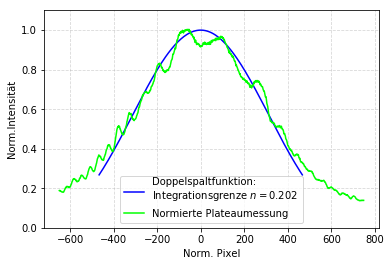

In [60]:
x, y = doppel_mod(best_fit)
plt.figure()
plt.plot(x, y, color='blue', 
         label="\n".join([r"Doppelspaltfunktion:", 
                          r'Integrationsgrenze $n={:.4}$'.format(best_fit)]))
plt.plot((x_mess - 650), y_mess/norm_inten_plateau, color='lime', label='Normierte Plateaumessung')
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel('Norm. Pixel')
plt.ylabel('Norm.Intensität')
plt.ylim((0,1.1))
plt.legend(loc='lower center')
plt.savefig("output/Anpassung_Plateau_Doppelspalt.pdf", format="pdf")

---

### Berechnung von k_y

In [61]:
#Brennweite
f = 0.08 #m
#Bildweite
b = 0.350 #m
db = 0.010
#Analysierspalt:
d_ana = 0.000020 *2 #m
dd_ana = 0.000005 * 2
#Spaltbreite:
d_d = np.mean([246, 221]) * 3.45*10**(-6) #m
dd_d = 0.5 * np.sqrt(2 * 10**2) * 3.45*10**(-6) #m
#Wellenlänge Laser:
lamb_laser = 532 * 10**(-9) #m

print(d_d, dd_d)

0.000805575 2.439518395093589e-05


In [62]:
ky_1 = 2 * np.pi * best_fit /(d_d * f/(b-f))
dky_1 = ky_1 * np.sqrt((dd_d/d_d)**2 + (dbest_fit/best_fit)**2 + (db/(b-f))**2)

print('k_{y,1} =', ky_1, '+/-', dky_1)

k_{y,1} = 5318.470811535628 +/- 275.36938810796664


In [63]:
ky_2 = 2 * np.pi * d_ana / (lamb_laser * f)
dky_2 = ky_2 * np.sqrt((dd_ana/d_ana)**2)

print('k_{y,2} =', ky_2, '+/-', dky_2)

k_{y,2} = 5905.249348852994 +/- 1476.3123372132486


In [64]:
sigma_ky = abs(ky_1 - ky_2)/np.sqrt(dky_1**2 + dky_2**2)
print('sigma_ky =', round(sigma_ky,2))

sigma_ky = 0.39


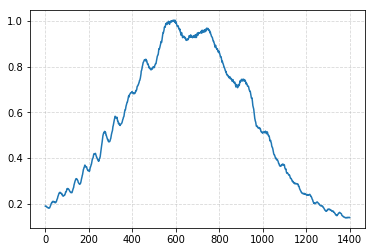

In [65]:
#%matplotlib ipympl
pixel, inten = np.loadtxt('./obj_doppel/objektbild_doppelspalt_plateau_inten.txt', skiprows=3, unpack=True)
plt.plot(pixel, inten/norm_inten_plateau)
plt.grid(alpha=0.5, linestyle='--')